In [98]:
#!conda activate tsr

In [99]:
#%pip install numpy scikit-learn pandas scipy seaborn matplotlib

In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB as naive_bias
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

In [101]:
dataset = pd.read_csv(f'data/penguins_size.csv')
dataset

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


In [102]:
dataset_param_dict = {
    'shape': tuple(dataset.shape),
    'feature_cnt': dataset.drop('species', axis='columns').shape[1],
    'target_class_cnt': len(dataset['species'].unique().tolist()), 
    'nan_prcnt': dataset.isna().sum().sum()/(dataset.size)
}

pd.DataFrame([dataset_param_dict])

,shape,feature_cnt,target_class_cnt,nan_prcnt
0,"(344, 7)",6,3,0.007475


In [103]:
select_features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

prep_dataset = dataset.dropna()
prep_dataset = prep_dataset[select_features + ['species']]
prep_dataset

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species
0,39.1,18.7,181.0,3750.0,Adelie
1,39.5,17.4,186.0,3800.0,Adelie
2,40.3,18.0,195.0,3250.0,Adelie
4,36.7,19.3,193.0,3450.0,Adelie
5,39.3,20.6,190.0,3650.0,Adelie
...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,Gentoo
340,46.8,14.3,215.0,4850.0,Gentoo
341,50.4,15.7,222.0,5750.0,Gentoo
342,45.2,14.8,212.0,5200.0,Gentoo


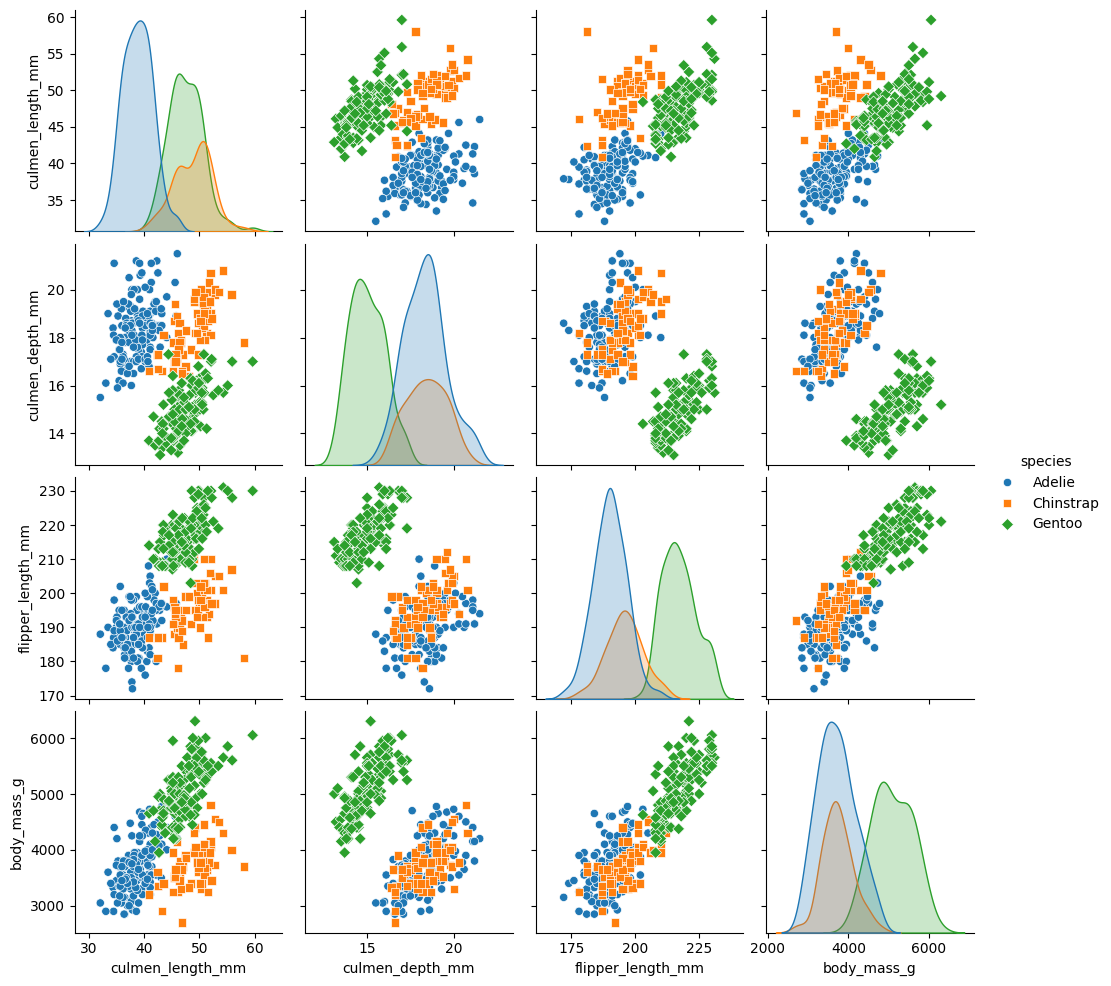

In [104]:
x = prep_dataset.drop('species', axis=1)
y = prep_dataset['species']

sns.pairplot(prep_dataset,
             vars=list(x.columns),
             hue=y.name,
             diag_kind='kde',
             markers=['o', 's', 'D']
)

plt.show()

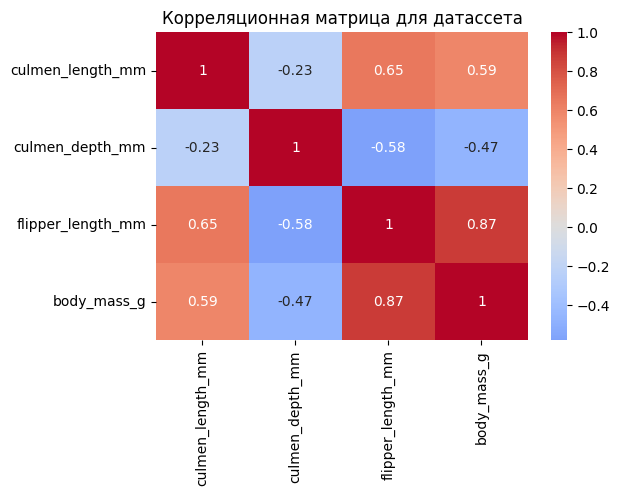

In [105]:
plt.figure(figsize=(6, 4)) 
sns.heatmap(x.corr(method='pearson'), annot=True, cmap='coolwarm', center=0)
plt.title(f'Корреляционная матрица для датассета')
plt.show()

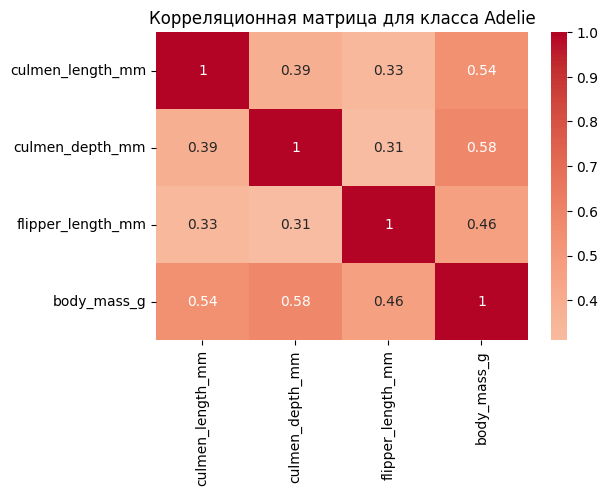

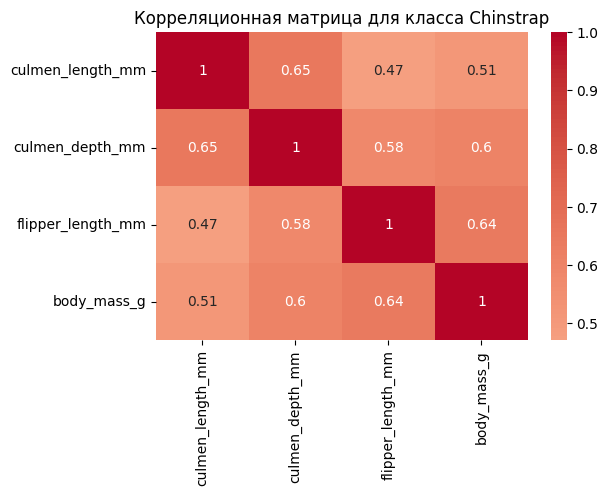

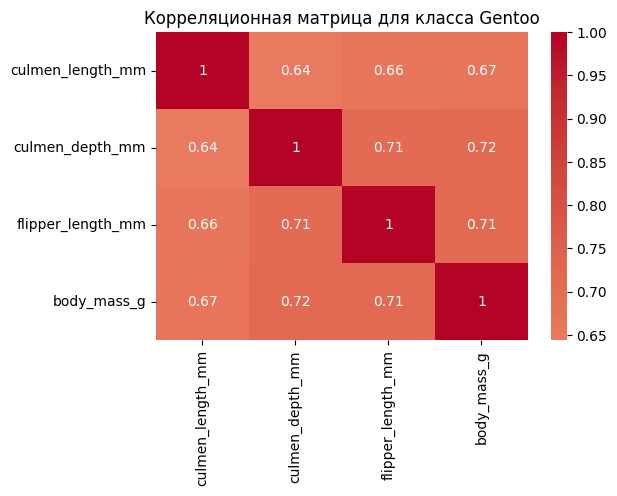

In [106]:
grouped_prep_dataset = prep_dataset.groupby(y.name)

correlation_by_class = {}
for class_name, group in grouped_prep_dataset:
    numeric_data = group.select_dtypes(include=['float64', 'int64'])
    correlation_by_class[class_name] = numeric_data.corr(method='pearson')


for class_name, corr_matrix in correlation_by_class.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title(f'Корреляционная матрица для класса {class_name}')
    plt.show()

In [107]:
adelie_dataset = prep_dataset.loc[prep_dataset[y.name] == 'Adelie']
chinstrap_dataset = prep_dataset.loc[prep_dataset[y.name] == 'Chinstrap']
gentoo_dataset = prep_dataset.loc[prep_dataset[y.name] == 'Gentoo']

In [108]:
target_dataset = pd.concat([adelie_dataset, chinstrap_dataset])
target_dataset

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species
0,39.1,18.7,181.0,3750.0,Adelie
1,39.5,17.4,186.0,3800.0,Adelie
2,40.3,18.0,195.0,3250.0,Adelie
4,36.7,19.3,193.0,3450.0,Adelie
5,39.3,20.6,190.0,3650.0,Adelie
...,...,...,...,...,...
215,55.8,19.8,207.0,4000.0,Chinstrap
216,43.5,18.1,202.0,3400.0,Chinstrap
217,49.6,18.2,193.0,3775.0,Chinstrap
218,50.8,19.0,210.0,4100.0,Chinstrap


In [109]:
X = target_dataset.drop('species', axis=1)


label_encoder = LabelEncoder()
y = target_dataset['species']
y_encoded = label_encoder.fit_transform(y)

features_names = X.columns

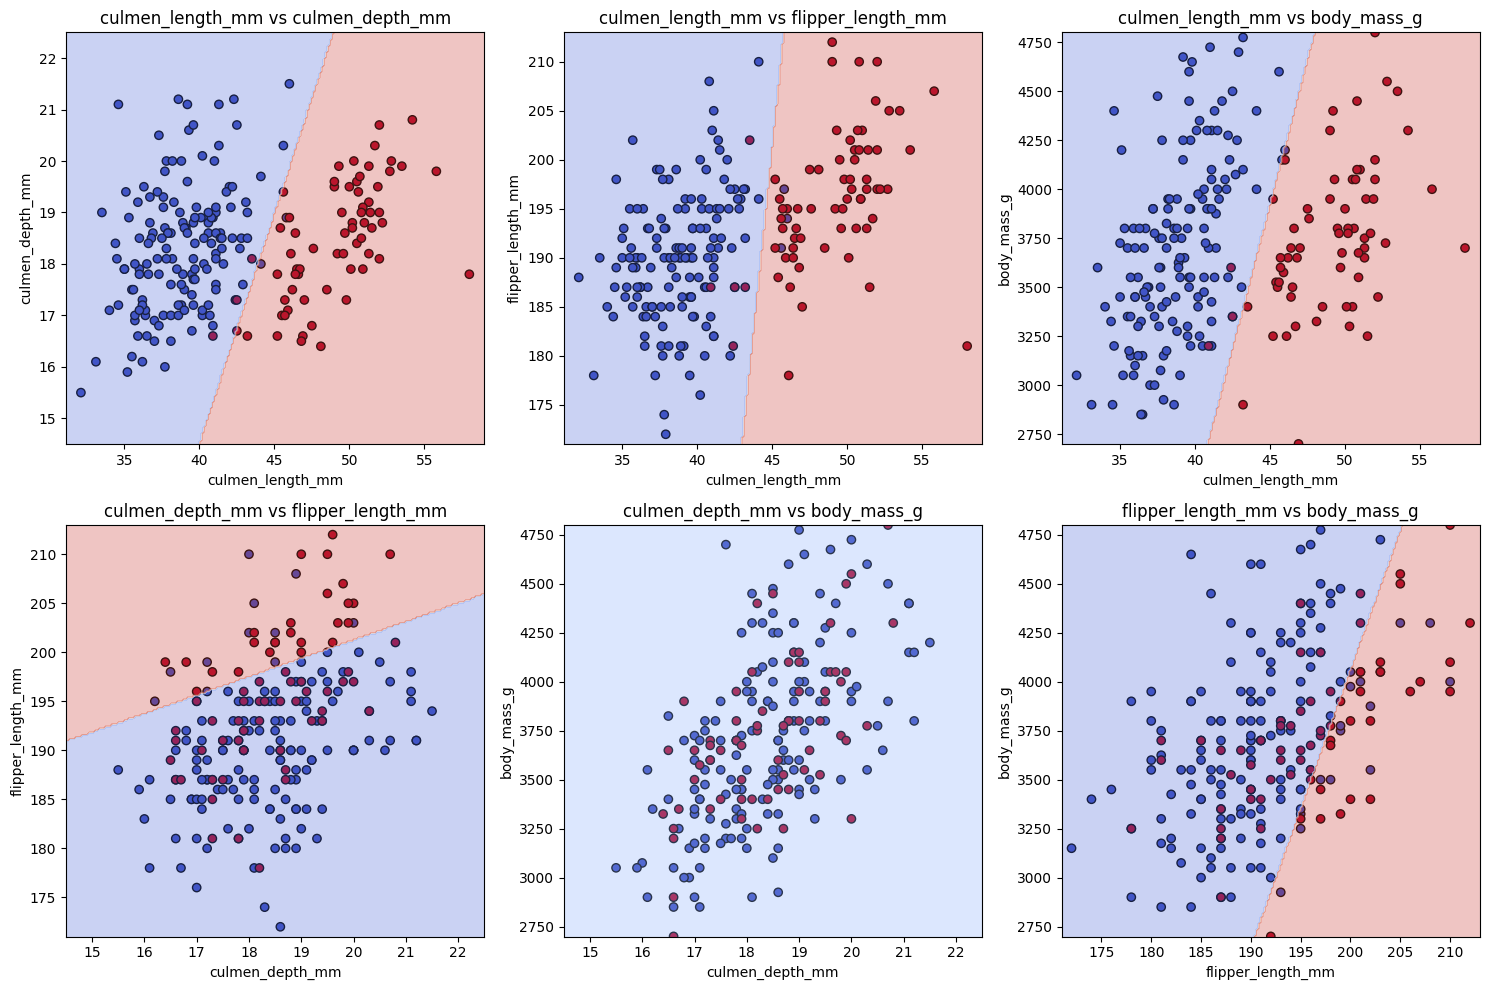

In [110]:
plt.figure(figsize=(15, 10))
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
for i, (fst, snd) in enumerate(pairs):
    plt.subplot(2, 3, i + 1)
    X_pair = X.iloc[:, [fst, snd]]
    lda_pair = LDA()
    lda_pair.fit(X_pair.values, y_encoded)

    plt.scatter(X_pair.iloc[:, 0], X_pair.iloc[:, 1], c=y_encoded, cmap='coolwarm', edgecolor='k')

    x_min, x_max = X_pair.iloc[:, 0].min() - 1, X_pair.iloc[:, 0].max() + 1
    y_min, y_max = X_pair.iloc[:, 1].min() - 1, X_pair.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    Z = lda_pair.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

    plt.xlabel(features_names[fst])
    plt.ylabel(features_names[snd])
    plt.title(f'{features_names[fst]} vs {features_names[snd]}')

plt.tight_layout()
plt.show()

c:\Users\user\Desktop\pitux\тср\lab_1\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


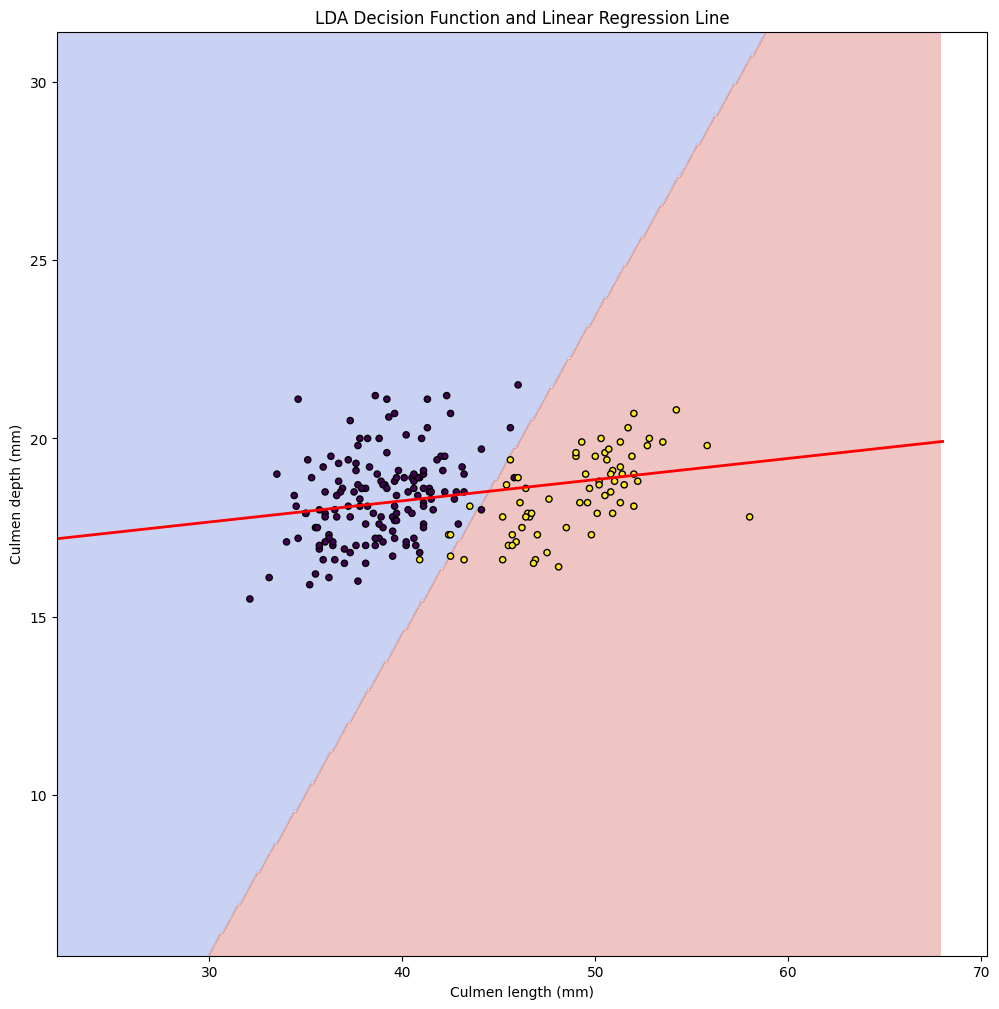

In [111]:
X = X[['culmen_length_mm', 'culmen_depth_mm']]
	
lda = LDA()
lda.fit(X.values, y_encoded)

X_reg = X[['culmen_length_mm']]
y_reg = X[['culmen_depth_mm']]

lin_reg = LinearRegression()
lin_reg.fit(X_reg, y_reg)

x_min, x_max = X['culmen_length_mm'].min() - 10, X['culmen_length_mm'].max() + 10
y_min, y_max = X['culmen_depth_mm'].min() - 10, X['culmen_depth_mm'].max() + 10
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),  
                     np.arange(y_min, y_max, 0.1))  

Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

reg_line_x = np.linspace(x_min, x_max, 100).reshape(-1, 1)
reg_line_y = lin_reg.predict(reg_line_x)

plt.figure(figsize=(12, 12))

plt.plot(reg_line_x, reg_line_y, color='red', linewidth=2)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

plt.scatter(X['culmen_length_mm'], X['culmen_depth_mm'], c=y_encoded, edgecolor='k', s=20)

plt.xlabel('Culmen length (mm)')
plt.ylabel('Culmen depth (mm)')
plt.title('LDA Decision Function and Linear Regression Line')

plt.show()

In [112]:
models = {
    'LDA': LDA(),
    'SVM': SVC(probability=True),
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': naive_bias()
}

In [113]:
def plot_decision_boundary(model, X, y_encoded, ax, model_name):
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_encoded, edgecolor='k', s=20)
    ax.set_xlabel('Culmen length (mm)')
    ax.set_ylabel('Culmen depth (mm)')
    ax.set_title(model_name)

c:\Users\user\Desktop\pitux\тср\lab_1\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
c:\Users\user\Desktop\pitux\тср\lab_1\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\user\Desktop\pitux\тср\lab_1\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\user\Desktop\pitux\тср\lab_1\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


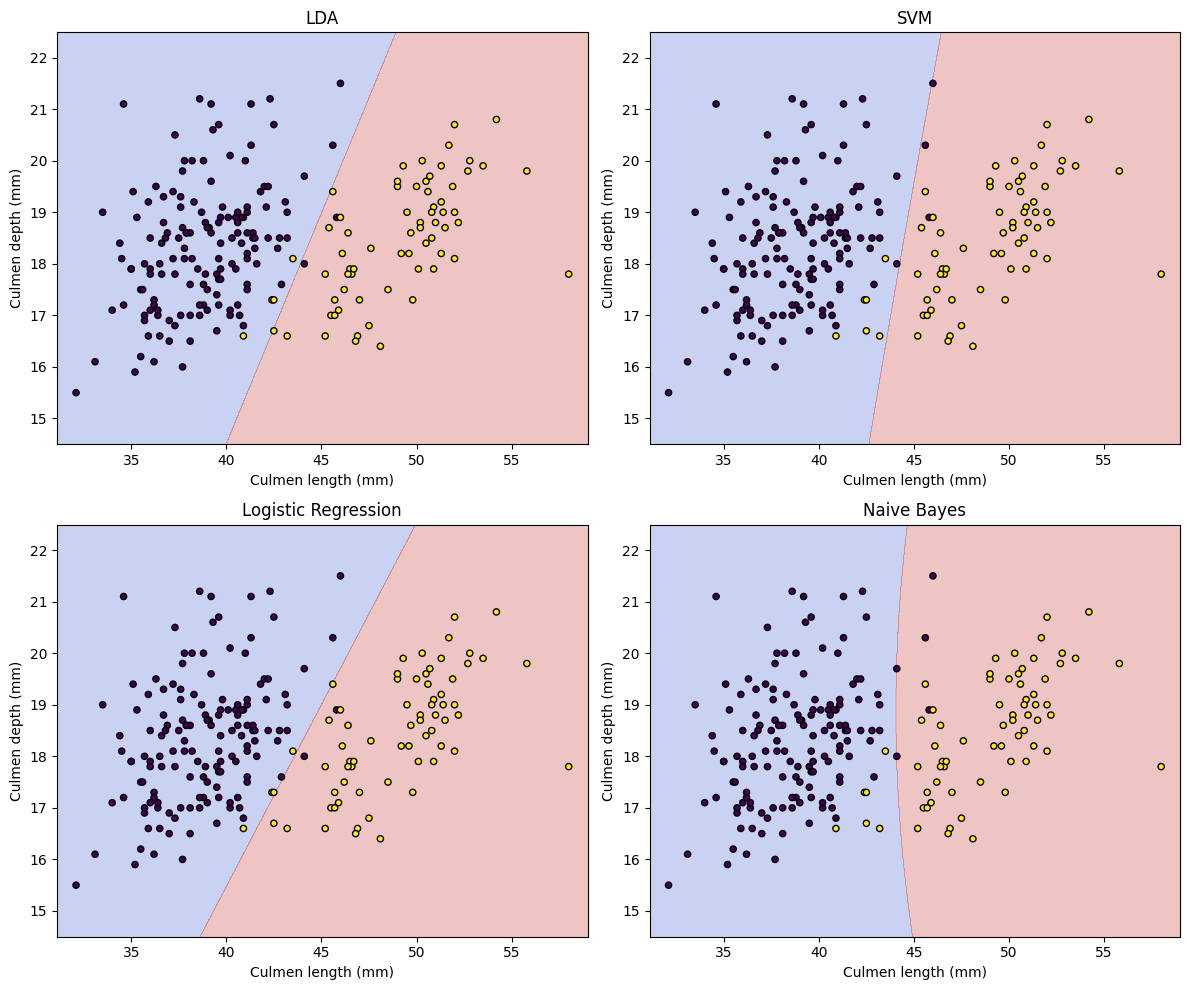

In [114]:
for model_name, model in models.items():
    model.fit(X, y_encoded)
    
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for ax, (model_name, model) in zip(axs.ravel(), models.items()):
    plot_decision_boundary(model, X, y_encoded, ax, model_name)

plt.tight_layout()
plt.show()

In [115]:
target_classes = ['Adelie', 'Gentoo']
filtered_dataset = prep_dataset[prep_dataset['species'].isin(target_classes)]

train_set, test_set = train_test_split(filtered_dataset, test_size=0.3, random_state=42)

X_train = train_set[['culmen_length_mm', 'culmen_depth_mm']]
y_train = train_set['species']

X_test = test_set[['culmen_length_mm', 'culmen_depth_mm']]
y_test = test_set['species']

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)



Confusion matrix LDA:
[[47  0]
 [ 1 32]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        47
           1       1.00      0.97      0.98        33

    accuracy                           0.99        80
   macro avg       0.99      0.98      0.99        80
weighted avg       0.99      0.99      0.99        80

Sensitivity: 0.97, Specificity: 1.00, Precision: 1.00, Recall: 0.97


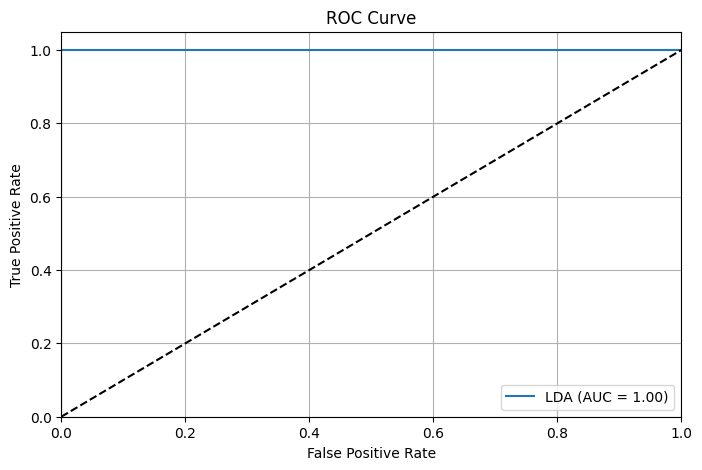


Confusion matrix SVM:
[[47  0]
 [ 1 32]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        47
           1       1.00      0.97      0.98        33

    accuracy                           0.99        80
   macro avg       0.99      0.98      0.99        80
weighted avg       0.99      0.99      0.99        80

Sensitivity: 0.97, Specificity: 1.00, Precision: 1.00, Recall: 0.97


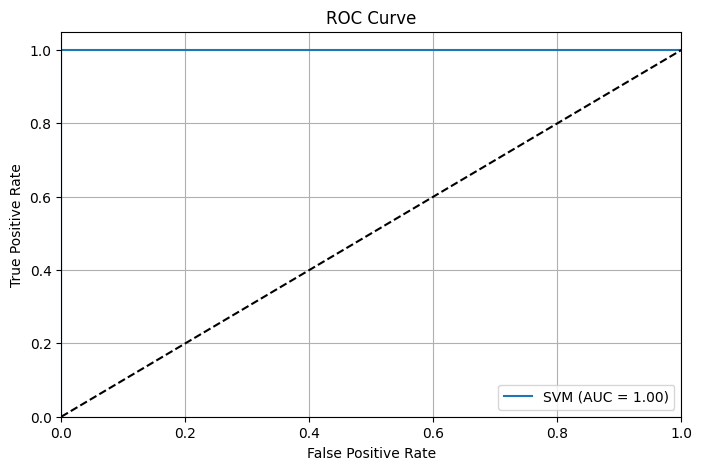


Confusion matrix Logistic Regression:
[[47  0]
 [ 1 32]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        47
           1       1.00      0.97      0.98        33

    accuracy                           0.99        80
   macro avg       0.99      0.98      0.99        80
weighted avg       0.99      0.99      0.99        80

Sensitivity: 0.97, Specificity: 1.00, Precision: 1.00, Recall: 0.97


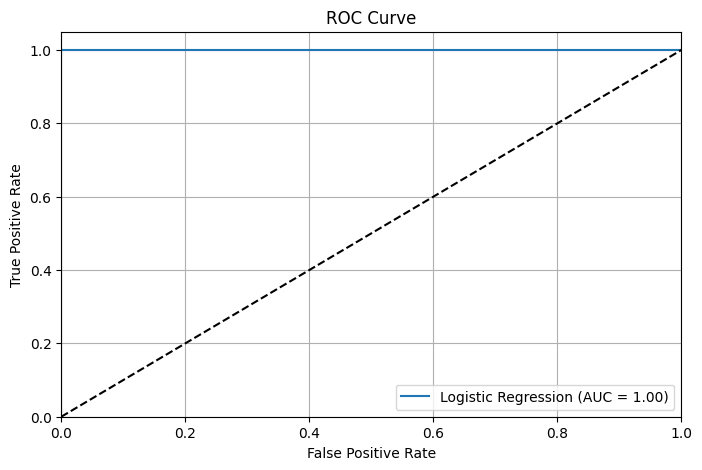


Confusion matrix Naive Bayes:
[[47  0]
 [ 1 32]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        47
           1       1.00      0.97      0.98        33

    accuracy                           0.99        80
   macro avg       0.99      0.98      0.99        80
weighted avg       0.99      0.99      0.99        80

Sensitivity: 0.97, Specificity: 1.00, Precision: 1.00, Recall: 0.97


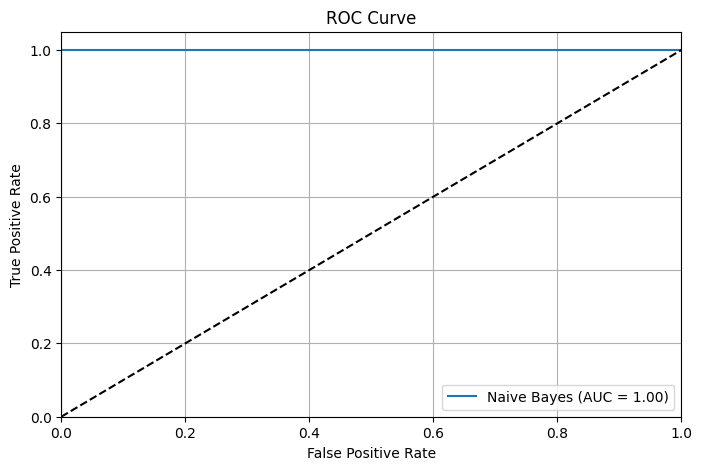

In [116]:
def evaluate_model(model, X_train, y_train_encoded, X_test, y_test_encoded, model_name):
    model.fit(X_train, y_train_encoded)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  

    cm = confusion_matrix(y_test_encoded, y_pred)
    print(f"\nConfusion matrix {model_name}:\n{cm}")

    print(classification_report(y_test_encoded, y_pred))

    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    print(f"Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

    fpr, tpr, _ = roc_curve(y_test_encoded, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


for model_name, model in models.items():
    evaluate_model(model, X_train, y_train_encoded, X_test, y_test_encoded, model_name)